##### **Brent Price Prediction**

This is an example of brent price prediction. We know brent price is non-linear and not easily predicted
Brent Prices come from scrapping web sites on oil prices

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score



#### Load and Cleanse csv into Dataframe

In [4]:
df = pd.read_csv('./data/brent_price.csv')
# date is not date transform it into datetime
df['date'] = pd.to_datetime(df['DATE'])
df.dtypes
len_dataframe = len(df)
print(len_dataframe)
df.columns

4587


Index(['DATE', 'DCOILBRENTEU', 'date'], dtype='object')

In [5]:
df.describe()

,DCOILBRENTEU,date
count,4587.000000,4587
mean,75.458886,2014-01-25 11:08:21.504250880
min,9.120000,2005-01-04 00:00:00
25%,56.095000,2009-07-13 12:00:00
50%,70.550000,2014-02-06 00:00:00
75%,98.640000,2018-08-07 12:00:00
max,143.950000,2023-02-13 00:00:00
std,25.245634,NaN


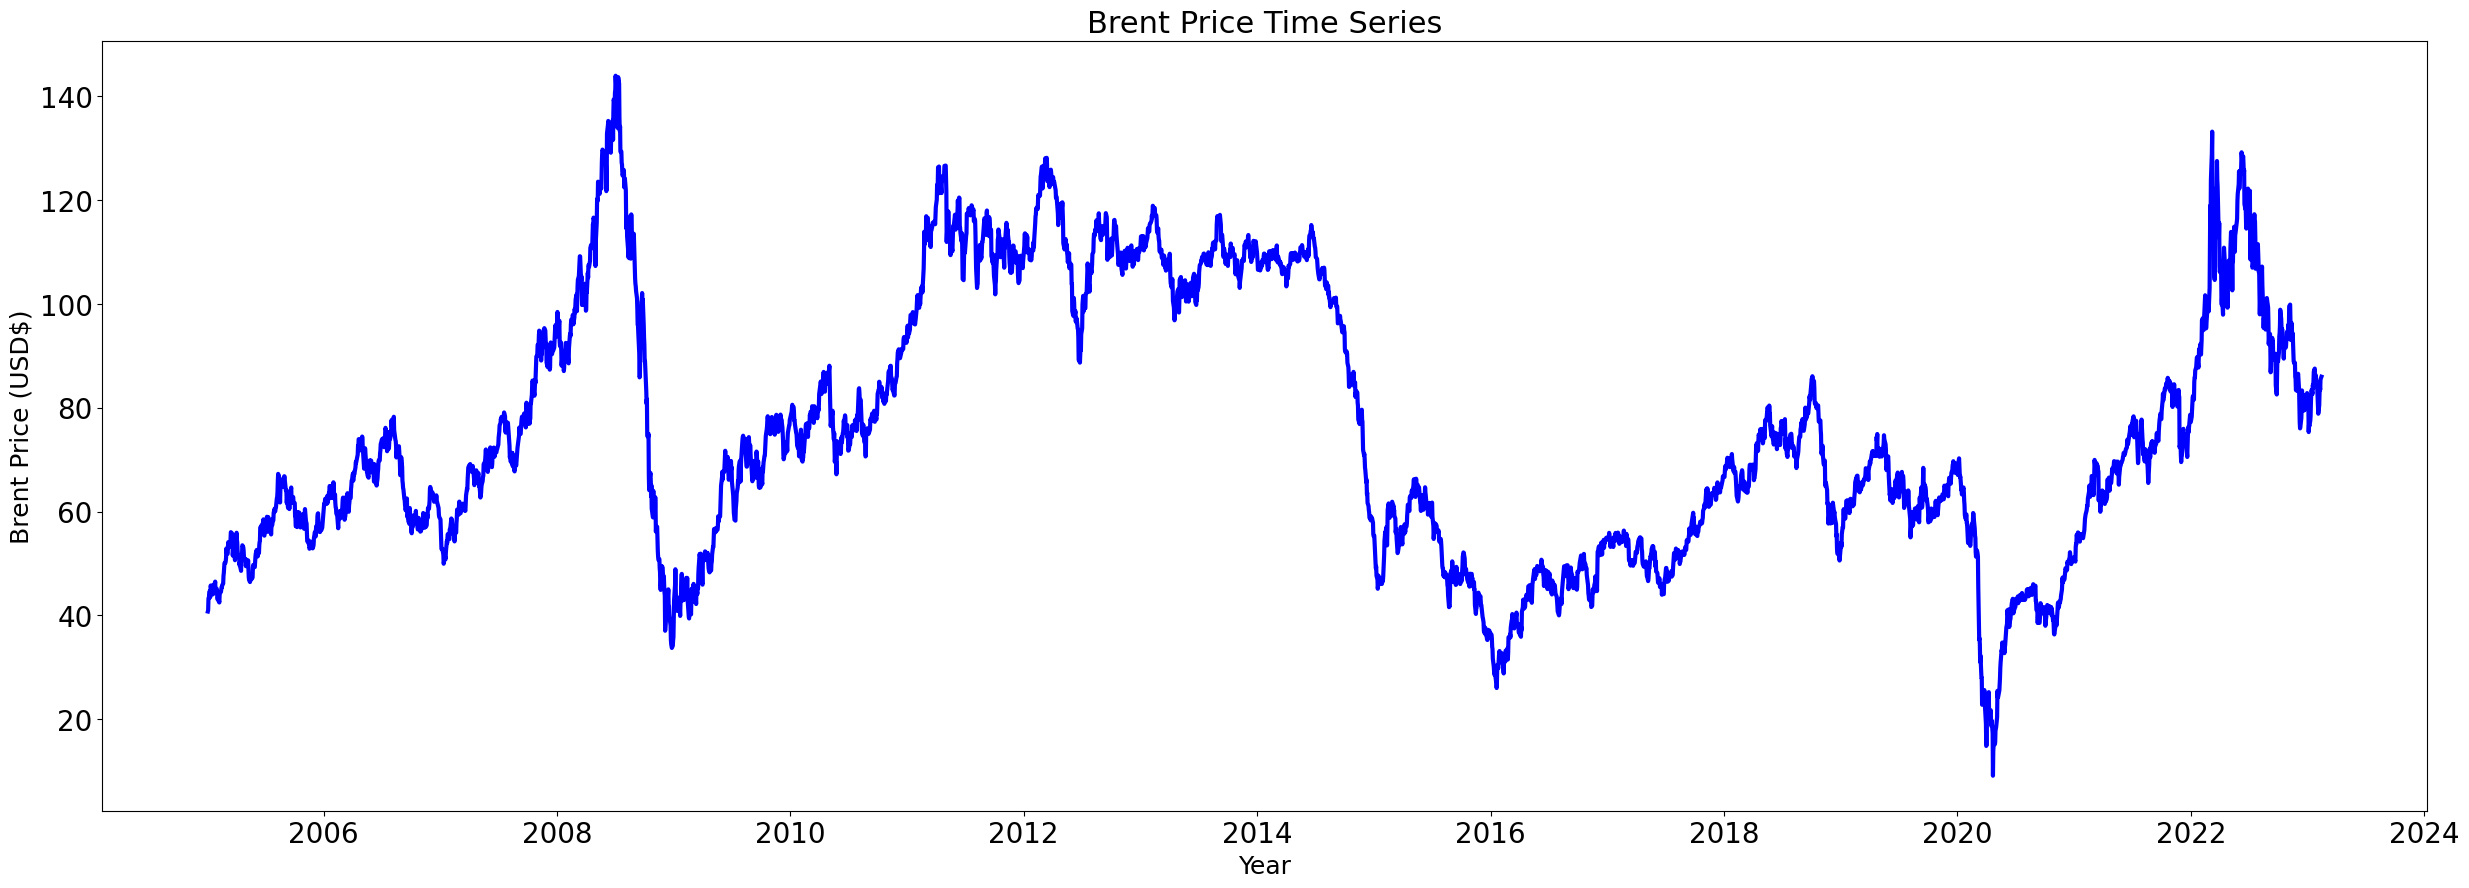

In [6]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))


ax.plot(df['date'],df['DCOILBRENTEU'],color='blue',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

#### Time Series Decomposition to analyze Seasonality and Trend

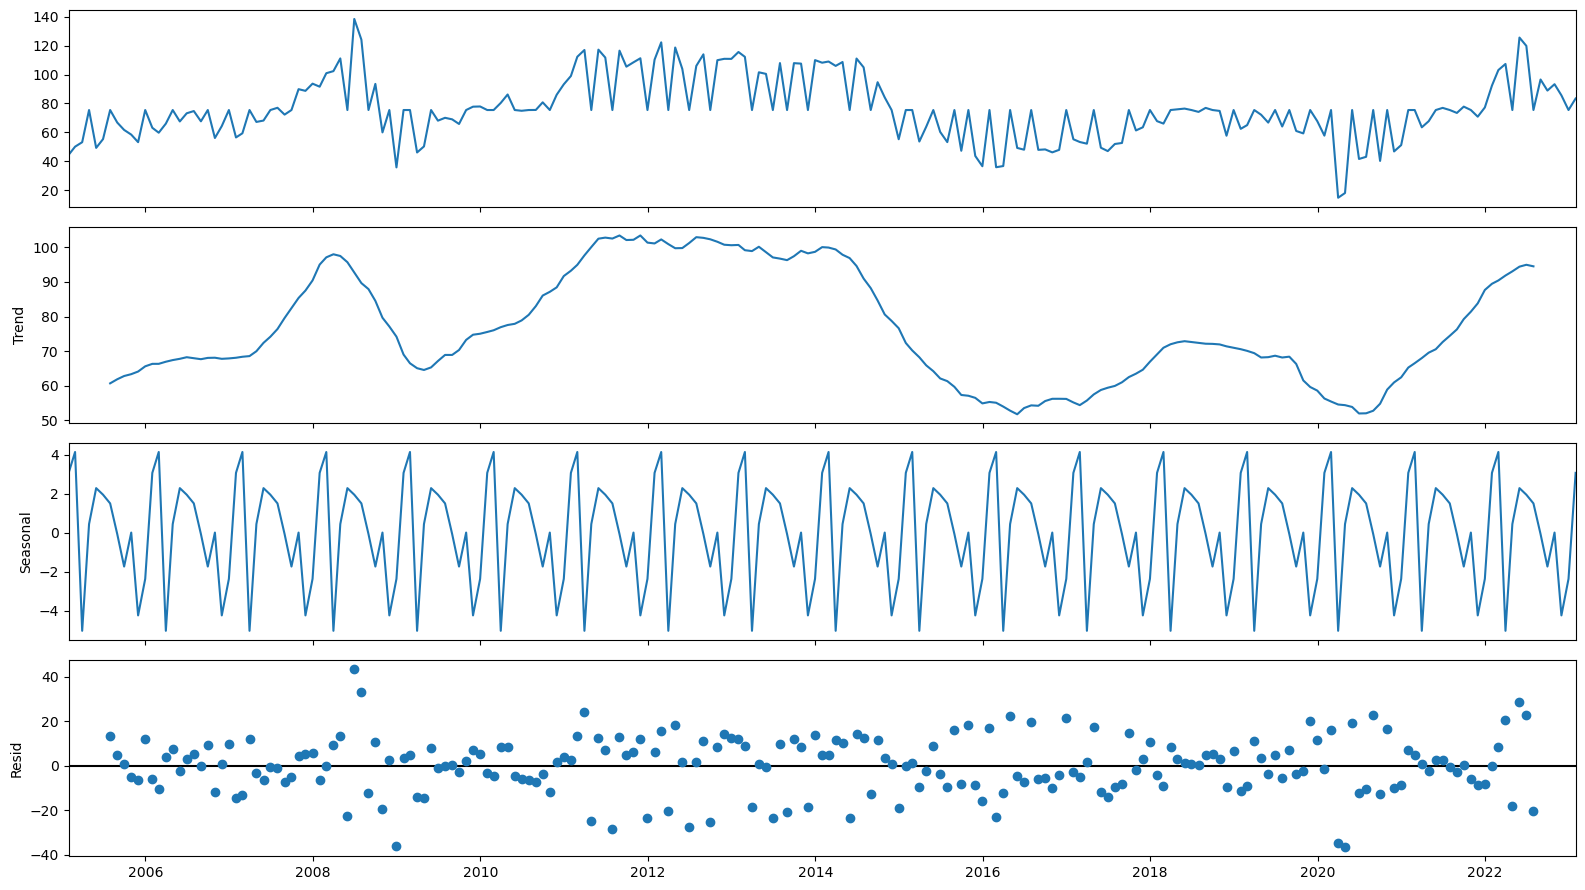

In [11]:
plt.rcParams["figure.figsize"] = [16,9]
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

dfa = df
dfa.reset_index(drop=True,inplace=True)
dfa = dfa.set_index('date').asfreq('m')
dfa = dfa.fillna(df.mean(numeric_only=True))
#s = sm.tsa.seasonal(dfa['DCOILBRENTEU'])
dfa = dfa.drop(columns=['DATE'])

decomposition = seasonal_decompose(dfa)
decomposition.plot()
plt.show()

In [12]:
# Stationarity test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
check_stationarity(dfa['DCOILBRENTEU'])

ADF Statistic: -2.725283
p-value: 0.069764
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Non-stationary


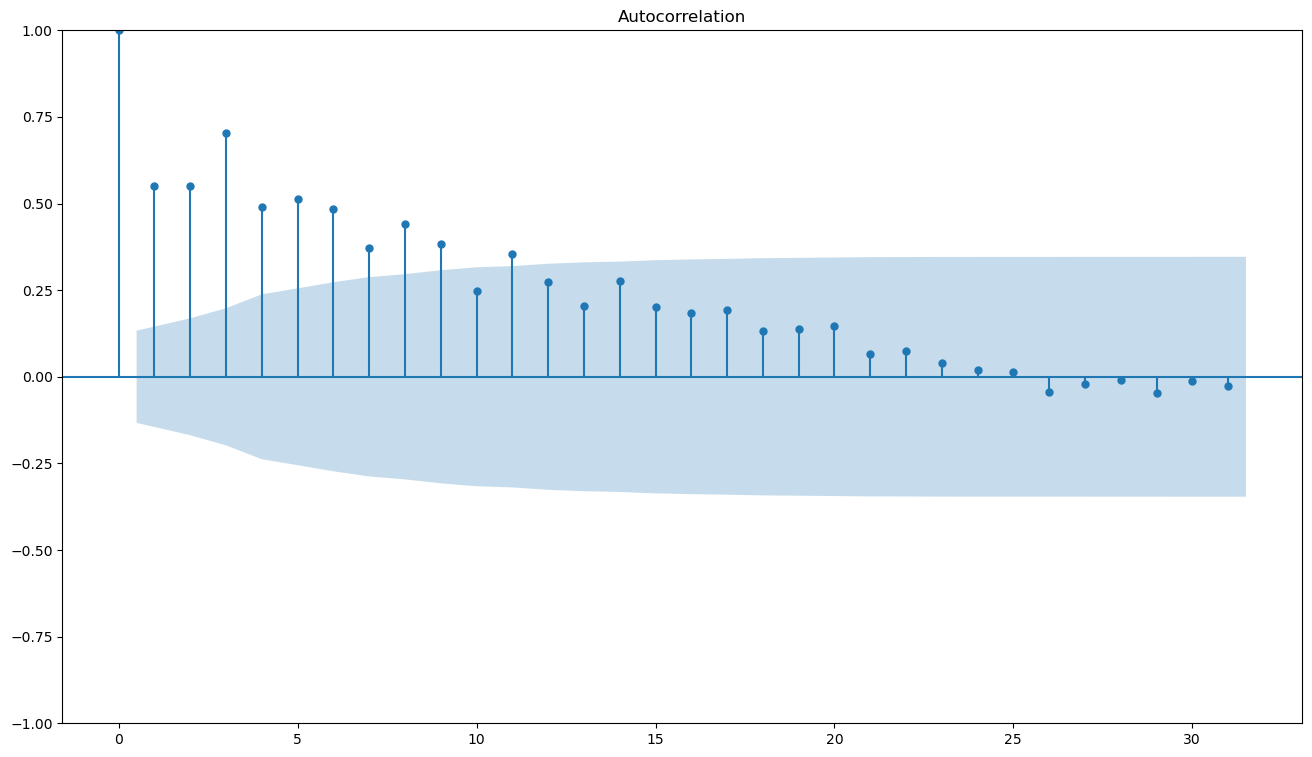

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dfa, lags = 31) 
plt.show()

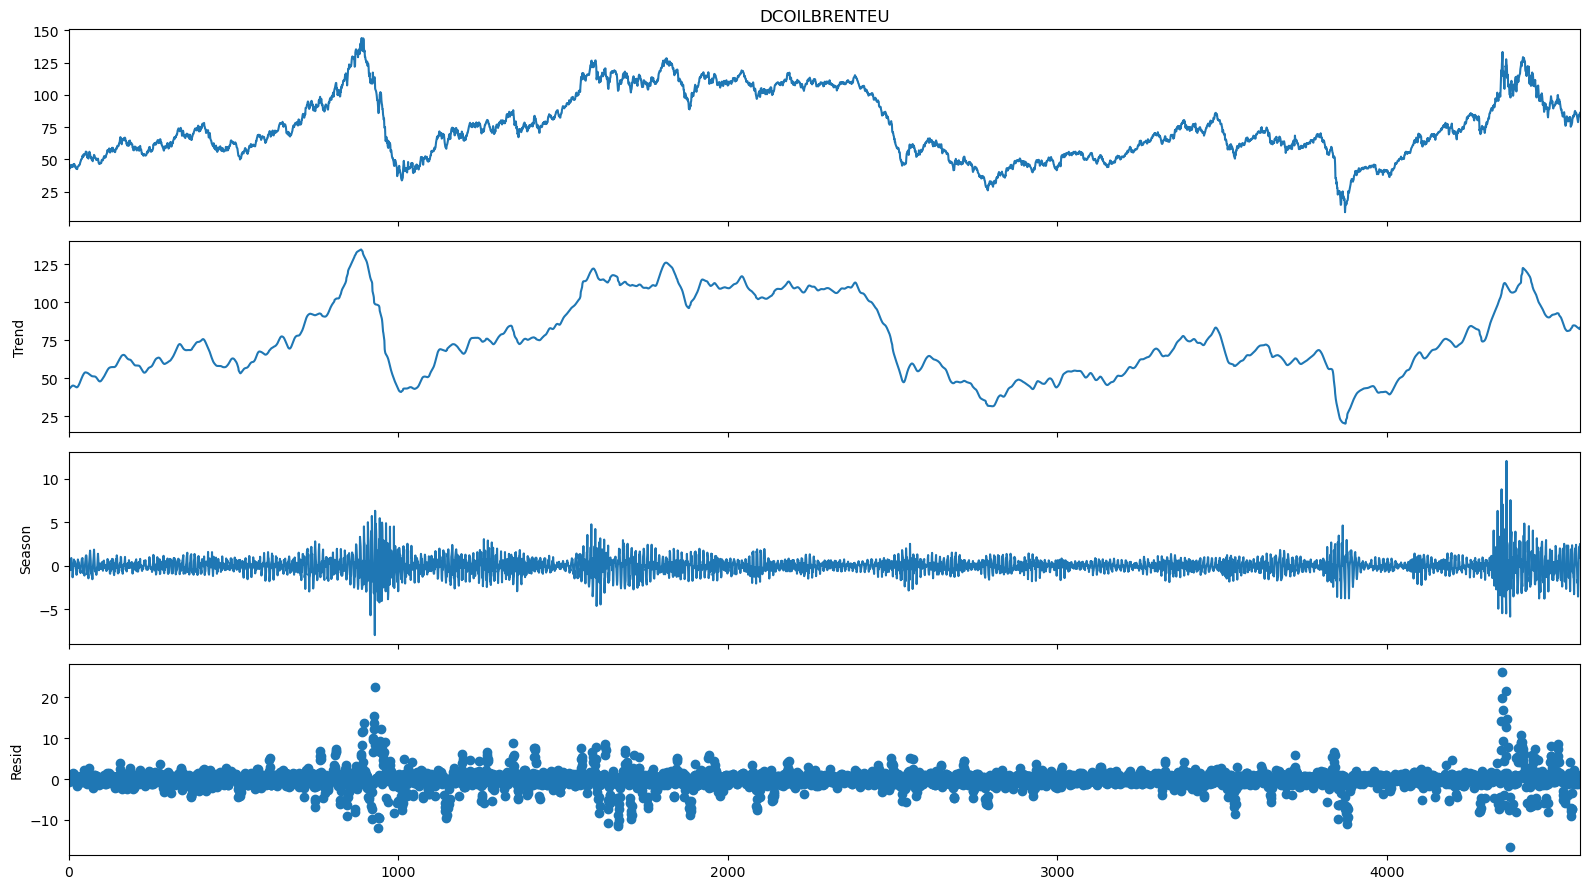

In [14]:
plt.rcParams["figure.figsize"] = [16,9]
stl = STL(df['DCOILBRENTEU'], period=12, robust=True)
result = stl.fit()
result.plot() 
plt.show()

In [15]:
# Time series is clearly without seasonality and trend
# We transform the prediction into a supervised learning approach
# <steps> - <prediction>
# How many steps can perform a horizon prediction?
ahead = 90     # we will perform at 90 days
lag = 50      # we use 10 steps as an example
length = len(df)

print('Number of steps (shape)', df.shape)
# we create a numpy array with all the steps
prices = df[["DCOILBRENTEU"]].to_numpy()

Number of steps (shape) (4587, 3)


In [16]:
prices

array([[40.75],
       [41.  ],
       [43.25],
       ...,
       [83.46],
       [85.46],
       [85.98]])

In [17]:
s = prices
lvect = []

trainsize = len(s)
lvect = []
lvect2 = []
for i in range(lag, trainsize-lag-ahead):
   lvect.append(s[i:i+lag])
   lvect2.append(s[i+ahead+lag])   
X = np.stack(lvect, axis=1)
y = np.stack(lvect2, axis=1)
y = np.swapaxes(y, 1, 0)
X = np.swapaxes(X, 0, 1)
X = np.squeeze(X)
y = np.squeeze(y)

In [18]:
# Split Train and Test
len_series = len(X)
cut = int(len_series*0.8)
train_x = X[:cut,:]
test_x  = X[cut:len_series,:]

train_y = y[:cut]
test_y  = y[cut:len_series]

In [19]:
print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("=============================================================")

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (3517, 50)  y_training: :  (3517,)
shape x_test     :  (880, 50)  y_test      :  (880,)


In [20]:
XGB = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.11, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=1, n_estimators=100,
       n_jobs=1, nthread=None, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

XGB.fit(train_x, train_y)
y_hat = XGB.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.5428549239897877
MAPE Value: 0.2652401807100357


In [21]:
#Create a column for y_hat
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, y_hat))
prevision = np.concatenate((prevision, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(prevision)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, prevision))
df['prevision'] = prevision
df['prevision'] = df['prevision'].astype(float)

In [22]:
#Create a column for y_test
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, test_y))
zz = np.concatenate((zz, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(zz)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, zz))
df['real'] = zz
df['real'] = df['real'].astype(float)

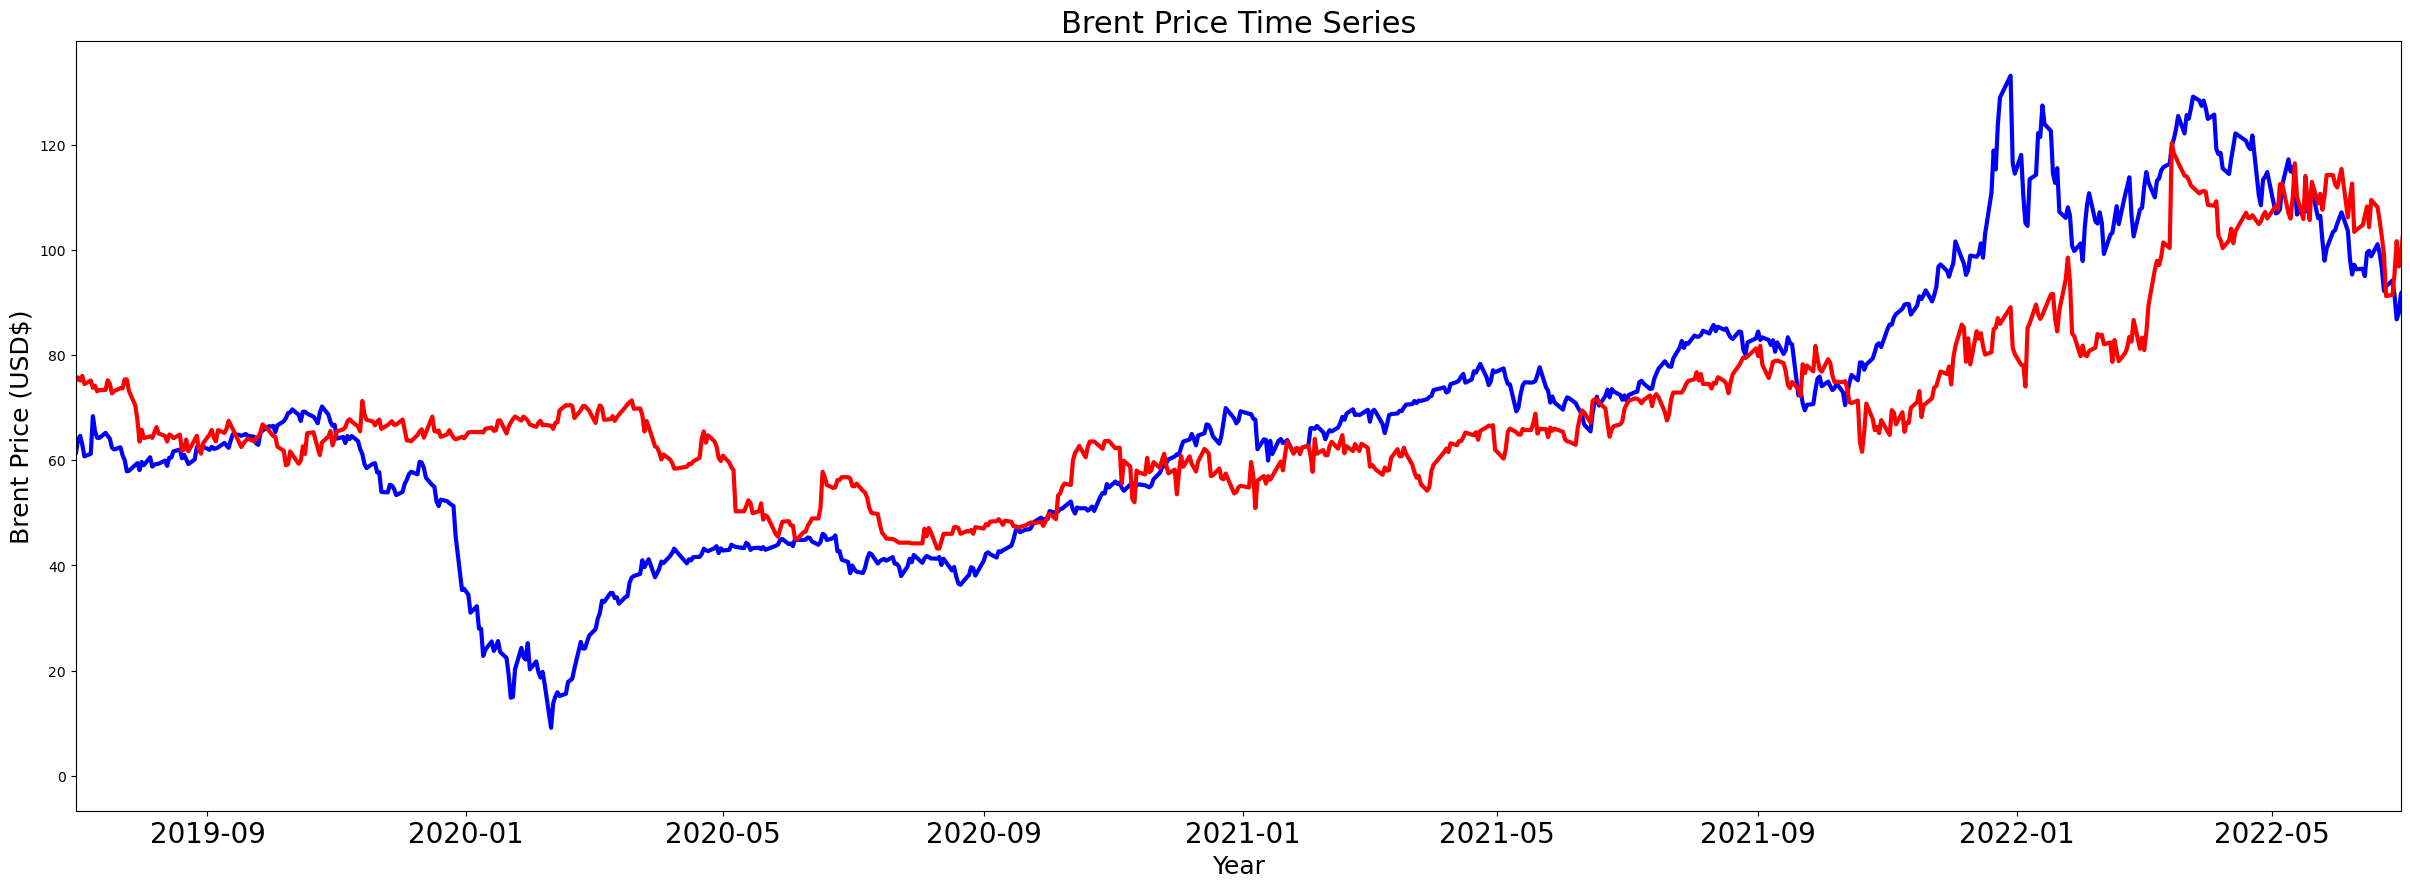

In [23]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df['date'],df['real'],color='blue',linewidth=3.0)
ax.plot(df['date'],df['prevision'],color='red',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.xlim('2019-07','2022-07')
#plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

In [24]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(max_depth=2, random_state=0)
RF.fit(train_x, train_y)
y_hat = RF.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.5335373522725468
MAPE Value: 0.2817848032833022


In [25]:
from sklearn.svm import SVR
SVM = SVR(kernel = 'rbf')
SVM.fit(train_x, train_y)

SVM.fit(train_x, train_y)
y_hat = SVM.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.512870354711769
MAPE Value: 0.2887703415279842


In [26]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.8.0
numpy               1.26.4
pandas              2.1.4
session_info        1.0.0
sklearn             1.2.2
statsmodels         0.14.0
xgboost             2.0.3
-----
IPython             8.20.0
jupyter_client      8.6.0
jupyter_core        5.5.0
jupyterlab          4.0.11
notebook            7.0.8
-----
Python 3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-03-26 18:23
